## SVM Binary Toxic Classifier - Balanced learning

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from imblearn.under_sampling import RandomUnderSampler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, classification_report

In [2]:
# utility function
def make_confusion_matrix( cfm, title):
    group_names = ['TN','FP','FN','TP']

    group_counts = ["{0:0.0f}".format(value) for value in
                cfm.flatten()]

    group_percentages = ["{0:.2%}".format(value) for value in
                     cfm.flatten()/np.sum(cfm)]

    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]

    labels = np.asarray(labels).reshape(2,2)
    plt.title(title)
    
    sns.heatmap(cfm, annot=labels, fmt="", cmap='Blues')
    plt.ylabel('True Label', fontsize=12)
    plt.xlabel('Predicted',fontsize=12)

In [3]:
from sklearn.metrics import roc_curve,auc

def plot_roc_curve(y_test, prediction, name_model):
    test_fpr, test_tpr, te_thresholds = roc_curve(y_test, prediction)

    plt.grid()
    auc_score = round(auc(test_fpr, test_tpr),2)
    plt.plot(test_fpr, test_tpr, label=f"{name_model} - AUC ="+ str(auc_score))
    plt.plot([0,1],[0,1],'r--')
    plt.legend()
    plt.xlabel("True Positive Rate")
    plt.ylabel("False Positive Rate")
    plt.title(f" AUC(ROC curve) - {name_model}")
    plt.grid(color='black', linestyle='', linewidth=0.5)
    plt.show()

In [4]:
df = pd.read_csv('../data/alldata-balanced-cleaned.zip', compression='zip')
data = 'tokenized_stemmed'
target = 'toxicity'

In [5]:
df.head()

,id,comment_text,clean_text,tokenized,tokenized_no_stopwords,tokenized_stemmed,tokenized_pos,tokenized_lemmatized,tokenized_lemmatized_pos,tokenized_bigram,toxicity
0,c0946290dc76ce60,"your buddy tyto alba is much more friendly, pe...",your buddy tyto alba is much more friendly peh...,"['your', 'buddy', 'tyto', 'alba', 'is', 'much'...","['buddy', 'tyto', 'alba', 'much', 'friendly', ...","['buddi', 'tyto', 'alba', 'much', 'friendli', ...","[('buddy', 'NN'), ('tyto', 'NN'), ('alba', 'RB...","['buddy', 'tyto', 'alba', 'much', 'friendly', ...","['buddy', 'tyto', 'alba', 'much', 'friendly', ...","[('buddy', 'tyto'), ('tyto', 'alba'), ('alba',...",0
1,9f7132cdba6829e6,""" \n\n == """"Reception"""" 6 June 2013 == \n\n I'...",reception 6 june 2013 i have added back...,"['reception', '6', 'june', '2013', 'i', 'have'...","['reception', '6', 'june', '2013', 'added', 'b...","['recept', '6', 'june', '2013', 'ad', 'back', ...","[('reception', 'NN'), ('6', 'CD'), ('june', 'N...","['reception', '6', 'june', '2013', 'added', 'b...","['reception', '6', 'june', '2013', 'add', 'bac...","[('reception', '6'), ('6', 'june'), ('june', '...",0
2,92ce6baadfc370c8,"In an older interview, Ogre described the musi...",in an older interview ogre described the music...,"['in', 'an', 'older', 'interview', 'ogre', 'de...","['older', 'interview', 'ogre', 'described', 'm...","['older', 'interview', 'ogr', 'describ', 'musi...","[('older', 'JJR'), ('interview', 'NN'), ('ogre...","['older', 'interview', 'ogre', 'described', 'm...","['old', 'interview', 'ogre', 'described', 'mus...","[('older', 'interview'), ('interview', 'ogre')...",0
3,d5115e451e7bd281,== TFM == \n\n Good thinking. Gosh this is a m...,tfm good thinking gosh this is a mess do n...,"['tfm', 'good', 'thinking', 'gosh', 'this', 'i...","['tfm', 'good', 'thinking', 'gosh', 'mess', 'a...","['tfm', 'good', 'think', 'gosh', 'mess', 'arti...","[('tfm', 'RB'), ('good', 'JJ'), ('thinking', '...","['tfm', 'good', 'thinking', 'gosh', 'mess', 'a...","['tfm', 'good', 'thinking', 'gosh', 'mess', 'a...","[('tfm', 'good'), ('good', 'thinking'), ('thin...",0
4,71407371449cfe87,== The real reason detainees should be left in...,the real reason detainees should be left in g...,"['the', 'real', 'reason', 'detainees', 'should...","['real', 'reason', 'detainees', 'left', 'gitmo...","['real', 'reason', 'detaine', 'left', 'gitmo',...","[('real', 'JJ'), ('reason', 'NN'), ('detainees...","['real', 'reason', 'detainee', 'left', 'gitmo'...","['real', 'reason', 'detainee', 'leave', 'gitmo...","[('real', 'reason'), ('reason', 'detainees'), ...",0


In [6]:
df[target].value_counts()

0    22468
1    22468
Name: toxicity, dtype: int64

## Split Data

In [7]:
X_train, X_test, y_train, y_test = train_test_split(df[data], df[target], test_size=0.30, random_state=42, stratify=df[target]) 


In [8]:
print(f"Training set\n{y_train.value_counts()}\n")
print(f"Test set\n{y_test.value_counts()}\n")

Training set
1    15728
0    15727
Name: toxicity, dtype: int64

Test set
0    6741
1    6740
Name: toxicity, dtype: int64



## Support Vector Machine Classifiers - Hard Margin

In [9]:
#help(LinearSVC)

In [10]:
lsvc_pipeline = Pipeline([
    ('vect', CountVectorizer()),  
    ('tfidf', TfidfTransformer()),  
    ('clf-svc', LinearSVC(class_weight='balanced', verbose=1, random_state=42))])

lsvc_pipeline.fit(X_train,y_train)

[LibLinear]

Pipeline(steps=[('vect', CountVectorizer()), ('tfidf', TfidfTransformer()),
                ('clf-svc',
                 LinearSVC(class_weight='balanced', random_state=42,
                           verbose=1))])

In [11]:
y_pred = lsvc_pipeline.predict(X_test)
print(classification_report(y_test,y_pred ))

              precision    recall  f1-score   support

           0       0.89      0.91      0.90      6741
           1       0.90      0.88      0.89      6740

    accuracy                           0.89     13481
   macro avg       0.89      0.89      0.89     13481
weighted avg       0.89      0.89      0.89     13481



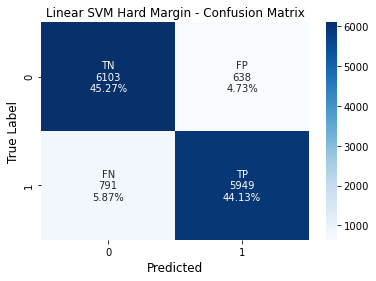

In [12]:
cf_matrix = confusion_matrix(y_test, y_pred)
make_confusion_matrix(cf_matrix, 'Linear SVM Hard Margin - Confusion Matrix')

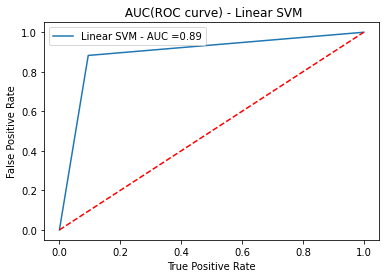

In [13]:
plot_roc_curve(y_test, y_pred, 'Linear SVM')

### SVM: Coarse GridSearch

In [14]:
lsvc_pipeline = Pipeline([
    ('vect', CountVectorizer()),  
    ('tfidf', TfidfTransformer()),  
    ('clf-svc', LinearSVC(class_weight='balanced', verbose=1, random_state=42))])

In [15]:
params = {'vect__ngram_range': [(1, 1), (1, 2)],
          'tfidf__use_idf': (True, False),
          'clf-svc__C': [0.2, 0.5, 1, 2, 3, 5, 10, 100],
         }

In [16]:
gs = GridSearchCV(estimator=lsvc_pipeline, param_grid=params, n_jobs=-1, cv=3)
gs_results = gs.fit(X_train, y_train)

[LibLinear]

In [17]:
print(f"best parameters:\n{gs_results.best_params_}\naccuracy: {gs_results.best_score_}")

best parameters:
{'clf-svc__C': 1, 'tfidf__use_idf': False, 'vect__ngram_range': (1, 2)}
accuracy: 0.8951518041646797


### SVM: Fine GrideSearch

In [18]:
# Fine Random search for C parameter in Linear SVM
params = {'vect__ngram_range': [(1, 1), (1, 2), (1,3)],
          'tfidf__use_idf': (True, False),
          'clf-svc__C': list(np.arange(0.5,1.5,0.05)),
         }

In [19]:
gs = GridSearchCV(estimator=lsvc_pipeline, param_grid=params, n_jobs=-1, cv=3)
gs_results = gs.fit(X_train, y_train)

[LibLinear]

In [20]:
print(f"best parameters:\n{gs_results.best_params_}\naccuracy: {gs_results.best_score_}")

best parameters:
{'clf-svc__C': 0.9000000000000004, 'tfidf__use_idf': False, 'vect__ngram_range': (1, 2)}
accuracy: 0.8954379271975839


### Retrain and test the model

In [21]:
lsvc_pipeline = Pipeline([
    ('vect', CountVectorizer(ngram_range=(1, 2))),  
    ('tfidf', TfidfTransformer(use_idf=False)),  
    ('clf-svc', LinearSVC(C=0.9000000000000004 ,class_weight='balanced', verbose=1, random_state=42))])

In [22]:
lsvc_pipeline.fit(X_train,y_train)

[LibLinear]

Pipeline(steps=[('vect', CountVectorizer(ngram_range=(1, 2))),
                ('tfidf', TfidfTransformer(use_idf=False)),
                ('clf-svc',
                 LinearSVC(C=0.9000000000000004, class_weight='balanced',
                           random_state=42, verbose=1))])

In [23]:
y_pred = lsvc_pipeline.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.89      0.91      0.90      6741
           1       0.91      0.89      0.90      6740

    accuracy                           0.90     13481
   macro avg       0.90      0.90      0.90     13481
weighted avg       0.90      0.90      0.90     13481



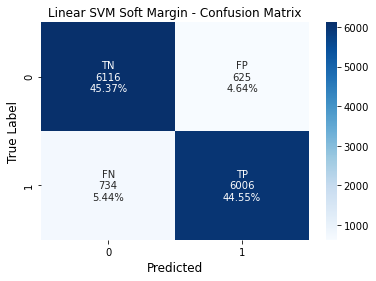

In [24]:
cf_matrix_soft = confusion_matrix(y_test, y_pred)
make_confusion_matrix(cf_matrix_soft, 'Linear SVM Soft Margin - Confusion Matrix')

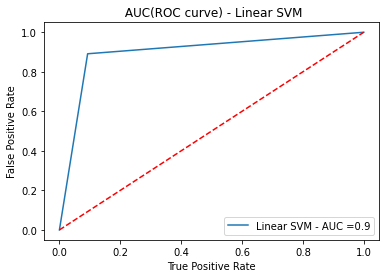

In [25]:
plot_roc_curve(y_test, y_pred, 'Linear SVM')